<a href="https://colab.research.google.com/github/tdr999/04-ELECTRONICA-M-A1-S1-CV1F-SIVA-2022/blob/main/bdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/code/officialsubhash/caltech101-classification
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/MyDrive/ic2')
import warnings
warnings.filterwarnings('ignore')
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Mounted at /content/gdrive
Num GPUs Available:  1


In [ ]:
!nvidia-smi

Sun Apr 30 07:20:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pickle

os.getcwd()

'/content/gdrive/MyDrive/ic2'

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
data_70_30, info_70_30 = tfds.load('caltech101',
                       split=['train[:70%]+test[:70%]', 'train[70%:]+test[70%:]'],
                       shuffle_files=False,
                       as_supervised=True,
                       with_info=True)
data_80_20, info_80_20 = tfds.load('caltech101',
                       split=['train[:80%]+test[:80%]', 'train[80%:]+test[80%:]'],
                       shuffle_files=False,
                       as_supervised=True,
                       with_info=True)
data_90_10, info_90_10 = tfds.load('caltech101',
                       split=['train[:90%]+test[:90%]', 'train[90%:]+test[90%:]'],
                       shuffle_files=False,
                       as_supervised=True,
                       with_info=True)

datasets = [
    [data_70_30, info_70_30],
    [data_80_20, info_80_20],
    [data_90_10, info_90_10]
]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incomplete7L3F0H/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.1.incomplete7L3F0H/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.1. Subsequent calls will reuse this data.


In [ ]:
classes = info_70_30.features['label'].names
n_classes = info_70_30.features['label'].num_classes

In [ ]:
labels = []
xs = [i for i in range(102)]
counts = [0 for i in range(102)]
for img, label in data_80_20[0].take(len(data_80_20[0])):
  # label = np.arange(n_classes)==int(label)
  # label = tf.cast(label, tf.float32)
  counts[label] = counts[label] + 1
  label = classes[label]
  labels.append(label)

print(labels)

['sea_horse', 'inline_skate', 'crab', 'beaver', 'headphone', 'saxophone', 'mandolin', 'hawksbill', 'menorah', 'starfish', 'airplanes', 'flamingo', 'watch', 'sea_horse', 'pagoda', 'rooster', 'background_google', 'camera', 'stop_sign', 'motorbikes', 'leopards', 'scorpion', 'background_google', 'bonsai', 'faces_easy', 'faces', 'faces_easy', 'leopards', 'faces_easy', 'llama', 'airplanes', 'faces_easy', 'dragonfly', 'faces', 'lotus', 'electric_guitar', 'hawksbill', 'binocular', 'lotus', 'beaver', 'trilobite', 'joshua_tree', 'gerenuk', 'tick', 'dolphin', 'motorbikes', 'gerenuk', 'leopards', 'faces_easy', 'watch', 'nautilus', 'bonsai', 'motorbikes', 'dolphin', 'pyramid', 'airplanes', 'motorbikes', 'accordion', 'menorah', 'motorbikes', 'umbrella', 'motorbikes', 'helicopter', 'faces_easy', 'pizza', 'ferry', 'windsor_chair', 'metronome', 'windsor_chair', 'ceiling_fan', 'crab', 'platypus', 'schooner', 'accordion', 'crocodile', 'crocodile', 'watch', 'ferry', 'cannon', 'platypus', 'panda', 'cup', '

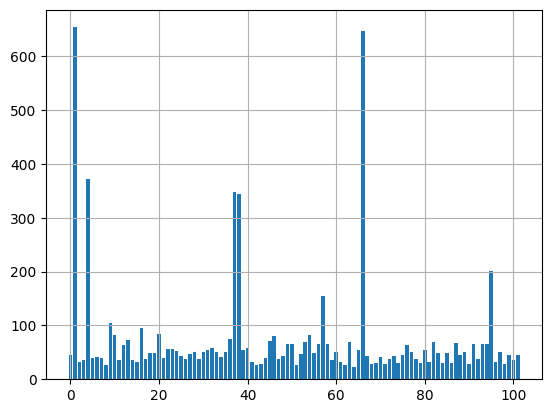

In [ ]:
plt.bar(xs, counts)
plt.grid()

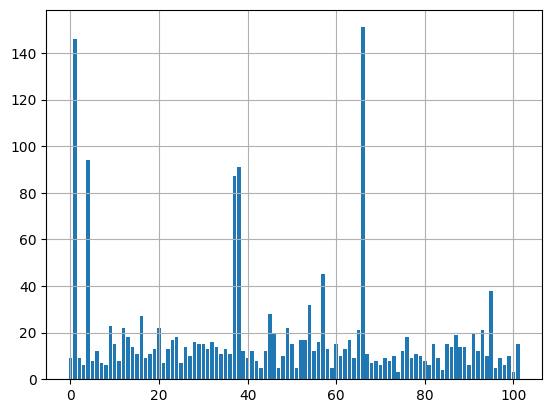

In [ ]:
#test distribution
labels = []
xs = [i for i in range(102)]
counts = [0 for i in range(102)]
for img, label in data_80_20[1].take(len(data_80_20[0])):
  # label = np.arange(n_classes)==int(label)
  # label = tf.cast(label, tf.float32)
  counts[label] = counts[label] + 1
  label = classes[label]
  labels.append(label)
plt.bar(xs, counts)
plt.grid()

In [ ]:
def image_process(image, label):
    image = tf.image.resize(image, size=(128,128))
    image = keras.applications.resnet50.preprocess_input(image)
    label = np.arange(n_classes)==int(label)
    label = tf.cast(label, tf.float32)
    return image, label

In [ ]:
def create_train_test(data):
    train_ds = data[0].map(image_process).shuffle(256).batch(32).prefetch(1)
    test_ds = data[1].map(image_process).batch(32).prefetch(1)
    return train_ds, test_ds

In [ ]:
def display_dataset_images(ds, nrows=3, ncols=4, figsize=(16,12)):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axs = np.ravel(axs)
    i = 0
    for image, label in ds.take(len(axs)):
        plt.sca(axs[i])
        plt.imshow(image.numpy())
        #plt.title(f"{classes[label]} - {image.numpy().shape}")
        plt.axis('off')
        i+=1
    plt.show()


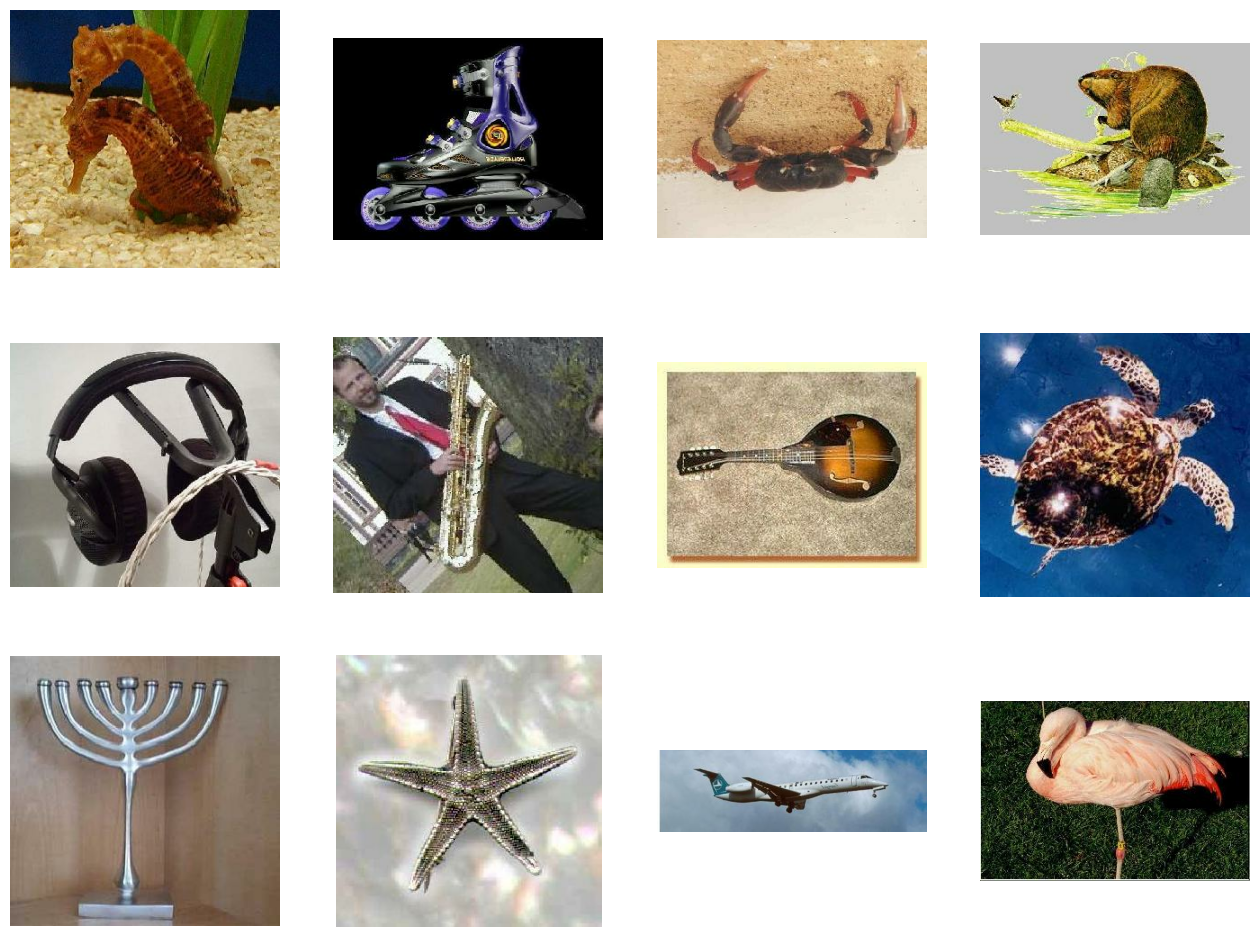

In [ ]:
display_dataset_images(data_90_10[0])

In [ ]:
#Resnet
import time
start = time.time()
end = time.time()
print("a durat " + str(end-start))

base_model = keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3),
                                                 include_top=False,
                                                 pooling='avg')

base_model.trainable = False

x = Dense(1024, 'relu')(base_model.output)
x = Dropout(0.5)(x)
x = Dense(64, 'relu')(x)

out = Dense(n_classes, 'softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=10,
                                               restore_best_weights=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                              patience=5)


# train_ds, test_ds = create_train_test(data_70_30)
# history_resnet = model.fit(train_ds, epochs=20,
#                     validation_data=test_ds,
#                     callbacks=[early_stopping, reduce_lr],
#                     verbose=1)
model.summary()


a durat 4.601478576660156e-05
94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  

In [ ]:
#tf.keras.utils.plot_model(mlp, to_file='mlp.png', show_shapes=True)

In [ ]:
# #testare diverse arhitecturi mlp
# train_ds, test_ds = create_train_test(data_70_30)
# mlp = Sequential()
# mlp.add(Input(shape=(128, 128, 3)))
# mlp.add(Flatten())
# mlp.add(Dense(1024, activation='relu')) #1
# mlp.add(Dense(512, activation='relu')) #2
# mlp.add(Dense(512, activation='relu')) #3
# mlp.add(Dense(256, activation='relu')) #4
# mlp.add(Dense(256, activation='relu')) #5
# mlp.add(Dense(128, activation='relu')) #6
# mlp.add(Dense(n_classes, activation='softmax')) #output
# mlp.summary()
# mlp.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# start = time.time()
# history_mlp = mlp.fit(train_ds, epochs=5,
#                   validation_data=test_ds,
#                   callbacks=[early_stopping, reduce_lr],
#                   verbose=1)
# end = time.time()
# print("a durat antrenarea " + str (end - start))
# with open('train_hist_mlp_70_30_e_5_arh_1', 'wb') as file_pi:
#   pickle.dump(history_mlp.history, file_pi)
# mlp.save("model_mlp_70_30_e_arh1")

In [ ]:
# #testare diverse arhitecturi mlp
# train_ds, test_ds = create_train_test(data_70_30)
# mlp = Sequential()
# mlp.add(Input(shape=(128, 128, 3)))
# mlp.add(Flatten())
# mlp.add(Dense(512, activation='relu')) #1
# mlp.add(Dense(256, activation='relu')) #2
# mlp.add(Dense(256, activation='relu')) #3
# mlp.add(Dense(128, activation='relu')) #4
# mlp.add(Dense(128, activation='relu')) #5
# mlp.add(Dense(128, activation='relu')) #6
# mlp.add(Dense(n_classes, activation='softmax')) #output
# mlp.summary()
# mlp.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# start = time.time()
# history_mlp = mlp.fit(train_ds, epochs=5,
#                   validation_data=test_ds,
#                   callbacks=[early_stopping, reduce_lr],
#                   verbose=1)
# end = time.time()
# print("a durat antrenarea " + str(end - start))
# with open('train_hist_mlp_70_30_e_5_arh_1', 'wb') as file_pi:
#   pickle.dump(history_mlp.history, file_pi)
# mlp.save("model_mlp_70_30_e_arh1")

In [ ]:
# #testare diverse arhitecturi mlp
# train_ds, test_ds = create_train_test(data_70_30)
# mlp = Sequential()
# mlp.add(Input(shape=(128, 128, 3)))
# mlp.add(Flatten())
# mlp.add(Dense(2048, activation='relu')) #1
# mlp.add(Dense(1024, activation='relu')) #2
# mlp.add(Dense(512, activation='relu')) #3
# mlp.add(Dense(512, activation='relu')) #4
# mlp.add(Dense(256, activation='relu')) #5
# mlp.add(Dense(128, activation='relu')) #6
# mlp.add(Dense(n_classes, activation='softmax')) #output
# mlp.summary()
# mlp.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# start = time.time()
# history_mlp = mlp.fit(train_ds, epochs=5,
#                   validation_data=test_ds,
#                   callbacks=[early_stopping, reduce_lr],
#                   verbose=1)
# end = time.time()
# print("a durat antrenarea " + str(end - start))
# with open('train_hist_mlp_70_30_e_5_arh_1', 'wb') as file_pi:
#   pickle.dump(history_mlp.history, file_pi)
# mlp.save("model_mlp_70_30_e_arh1")

In [ ]:
#construim combinatiile de modele
import itertools
from itertools import product
epoci = [10, 20, 30, 40, 50]
train_ds, test_ds = create_train_test(data_70_30)

for i in epoci:
  base_model = keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3),
                                                 include_top=False,
                                                 pooling='avg')

  base_model.trainable = False

  x = Dense(1024, 'relu')(base_model.output)
  x = Dropout(0.5)(x)
  x = Dense(64, 'relu')(x)

  out = Dense(n_classes, 'softmax')(x)

  model = Model(inputs=base_model.input, outputs=out)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=10,
                                                restore_best_weights=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                patience=5)

  start = time.time()
  history_resnet = model.fit(train_ds, epochs=i,
                      validation_data=test_ds,
                      callbacks=[early_stopping, reduce_lr],
                      verbose=1)
  end = time.time()
  print("a durat antrenarea " + str(end - start))
  with open('train_hist_resnet_70_30_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_resnet.history, file_pi)
  model.save("model_resnet_70_30_e_" + str(i))
  #mlp
  mlp = Sequential()

  mlp.add(Input(shape=(128, 128, 3)))
  mlp.add(Flatten())
  mlp.add(Dense(512, activation='relu')) #1
  mlp.add(Dense(256, activation='relu')) #2
  mlp.add(Dense(256, activation='relu')) #3
  mlp.add(Dense(128, activation='relu')) #4
  mlp.add(Dense(128, activation='relu')) #5
  mlp.add(Dense(128, activation='relu')) #6
  mlp.add(Dense(n_classes, activation='softmax')) #output
  mlp.summary()
  mlp.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  start = time.time()
  history_mlp = mlp.fit(train_ds, epochs=i,
                    validation_data=test_ds,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)
  end = time.time()
  print("a durat antrenarea " + str(end-start))
  with open('train_hist_mlp_70_30_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_mlp.history, file_pi)
  mlp.save("model_mlp_70_30_e_" + str(i))
  #https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object


Epoch 1/10
201/201 [==============================] - 34s 102ms/step - loss: 2.3052 - accuracy: 0.5010 - val_loss: 1.0849 - val_accuracy: 0.7295 - lr: 0.0010
Epoch 2/10
201/201 [==============================] - 14s 67ms/step - loss: 0.9057 - accuracy: 0.7616 - val_loss: 0.6859 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 3/10
201/201 [==============================] - 13s 65ms/step - loss: 0.5435 - accuracy: 0.8419 - val_loss: 0.6162 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 4/10
201/201 [==============================] - 12s 58ms/step - loss: 0.3926 - accuracy: 0.8844 - val_loss: 0.5834 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 5/10
201/201 [==============================] - 15s 74ms/step - loss: 0.3132 - accuracy: 0.9060 - val_loss: 0.5820 - val_accuracy: 0.8545 - lr: 0.0010
Epoch 6/10
201/201 [==============================] - 13s 62ms/step - loss: 0.2517 - accuracy: 0.9208 - val_loss: 0.5690 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 7/10
201/201 [==============================] - 12s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               25166336  
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 128)               1

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_16 (Dense)            (None, 512)               25166336  
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 128)              

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 49152)             0         
                                                                 
 dense_26 (Dense)            (None, 512)               25166336  
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dense_31 (Dense)            (None, 128)              

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 49152)             0         
                                                                 
 dense_36 (Dense)            (None, 512)               25166336  
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dense_38 (Dense)            (None, 256)               65792     
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dense_41 (Dense)            (None, 128)              

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 49152)             0         
                                                                 
 dense_46 (Dense)            (None, 512)               25166336  
                                                                 
 dense_47 (Dense)            (None, 256)               131328    
                                                                 
 dense_48 (Dense)            (None, 256)               65792     
                                                                 
 dense_49 (Dense)            (None, 128)               32896     
                                                                 
 dense_50 (Dense)            (None, 128)               16512     
                                                                 
 dense_51 (Dense)            (None, 128)              

In [ ]:
#construim combinatiile de modele si toate alea
import itertools
from itertools import product
epoci = [10, 20, 30, 40, 50]
train_ds, test_ds = create_train_test(data_80_20)

for i in epoci:
  base_model = keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3),
                                                 include_top=False,
                                                 pooling='avg')

  base_model.trainable = False

  x = Dense(1024, 'relu')(base_model.output)
  x = Dropout(0.5)(x)
  x = Dense(64, 'relu')(x)

  out = Dense(n_classes, 'softmax')(x)

  model = Model(inputs=base_model.input, outputs=out)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=10,
                                                restore_best_weights=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                patience=5)
  start = time.time()
  history_resnet = model.fit(train_ds, epochs=i,
                      validation_data=test_ds,
                      callbacks=[early_stopping, reduce_lr],
                      verbose=1)
  end = time.time()
  print(" a durat antrenarea " + str(end-start))
  with open('train_hist_resnet_80_20_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_resnet.history, file_pi)
  model.save("model_resnet_80_20_e_" + str(i))
  #mlp
  mlp = Sequential()

  mlp.add(Input(shape=(128, 128, 3)))
  mlp.add(Flatten())
  mlp.add(Dense(512, activation='relu')) #1
  mlp.add(Dense(256, activation='relu')) #2
  mlp.add(Dense(256, activation='relu')) #3
  mlp.add(Dense(128, activation='relu')) #4
  mlp.add(Dense(128, activation='relu')) #5
  mlp.add(Dense(128, activation='relu')) #6
  mlp.add(Dense(n_classes, activation='softmax')) #output
  mlp.summary()
  mlp.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  start = time.time()
  history_mlp = mlp.fit(train_ds, epochs=i,
                    validation_data=test_ds,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)
  print("a durat antrenarea " + str(end-start))
  with open('train_hist_mlp_80_20_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_mlp.history, file_pi)
  mlp.save("model_mlp_80_20_e_" + str(i))
  #https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object


Epoch 1/10
229/229 [==============================] - 28s 77ms/step - loss: 2.1481 - accuracy: 0.5259 - val_loss: 0.9214 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 2/10
229/229 [==============================] - 13s 55ms/step - loss: 0.8079 - accuracy: 0.7907 - val_loss: 0.6235 - val_accuracy: 0.8393 - lr: 0.0010
Epoch 3/10
229/229 [==============================] - 12s 52ms/step - loss: 0.5259 - accuracy: 0.8532 - val_loss: 0.5840 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 4/10
229/229 [==============================] - 12s 52ms/step - loss: 0.3701 - accuracy: 0.8884 - val_loss: 0.5381 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 5/10
229/229 [==============================] - 14s 59ms/step - loss: 0.2922 - accuracy: 0.9111 - val_loss: 0.5688 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 6/10
229/229 [==============================] - 14s 62ms/step - loss: 0.2677 - accuracy: 0.9165 - val_loss: 0.5909 - val_accuracy: 0.8650 - lr: 0.0010
Epoch 7/10
229/229 [==============================] - 14s 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 49152)             0         
                                                                 
 dense_76 (Dense)            (None, 512)               25166336  
                                                                 
 dense_77 (Dense)            (None, 256)               131328    
                                                                 
 dense_78 (Dense)            (None, 256)               65792     
                                                                 
 dense_79 (Dense)            (None, 128)               32896     
                                                                 
 dense_80 (Dense)            (None, 128)               16512     
                                                                 
 dense_81 (Dense)            (None, 128)              

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 49152)             0         
                                                                 
 dense_86 (Dense)            (None, 512)               25166336  
                                                                 
 dense_87 (Dense)            (None, 256)               131328    
                                                                 
 dense_88 (Dense)            (None, 256)               65792     
                                                                 
 dense_89 (Dense)            (None, 128)               32896     
                                                                 
 dense_90 (Dense)            (None, 128)               16512     
                                                                 
 dense_91 (Dense)            (None, 128)              

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 49152)             0         
                                                                 
 dense_96 (Dense)            (None, 512)               25166336  
                                                                 
 dense_97 (Dense)            (None, 256)               131328    
                                                                 
 dense_98 (Dense)            (None, 256)               65792     
                                                                 
 dense_99 (Dense)            (None, 128)               32896     
                                                                 
 dense_100 (Dense)           (None, 128)               16512     
                                                                 
 dense_101 (Dense)           (None, 128)              

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 49152)             0         
                                                                 
 dense_106 (Dense)           (None, 512)               25166336  
                                                                 
 dense_107 (Dense)           (None, 256)               131328    
                                                                 
 dense_108 (Dense)           (None, 256)               65792     
                                                                 
 dense_109 (Dense)           (None, 128)               32896     
                                                                 
 dense_110 (Dense)           (None, 128)               16512     
                                                                 
 dense_111 (Dense)           (None, 128)             

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 49152)             0         
                                                                 
 dense_116 (Dense)           (None, 512)               25166336  
                                                                 
 dense_117 (Dense)           (None, 256)               131328    
                                                                 
 dense_118 (Dense)           (None, 256)               65792     
                                                                 
 dense_119 (Dense)           (None, 128)               32896     
                                                                 
 dense_120 (Dense)           (None, 128)               16512     
                                                                 
 dense_121 (Dense)           (None, 128)             

In [ ]:
#construim combinatiile de modele
import itertools
from itertools import product
epoci = [10, 20, 30, 40, 50]
train_ds, test_ds = create_train_test(data_90_10)

for i in epoci:
  base_model = keras.applications.resnet50.ResNet50(input_shape=(128, 128, 3),
                                                 include_top=False,
                                                 pooling='avg')

  base_model.trainable = False

  x = Dense(1024, 'relu')(base_model.output)
  x = Dropout(0.5)(x)
  x = Dense(64, 'relu')(x)

  out = Dense(n_classes, 'softmax')(x)

  model = Model(inputs=base_model.input, outputs=out)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=10,
                                                restore_best_weights=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                                                patience=5)
  start = time.time()
  history_resnet = model.fit(train_ds, epochs=i,
                      validation_data=test_ds,
                      callbacks=[early_stopping, reduce_lr],
                      verbose=1)
  end = time.time()
  print("a durat antrenarea " + str(end-start))
  with open('train_hist_resnet_90_10_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_resnet.history, file_pi)
  model.save("model_resnet_90_10_e_" + str(i))
  #mlp
  mlp = Sequential()

  mlp.add(Input(shape=(128, 128, 3)))
  mlp.add(Flatten())
  mlp.add(Dense(512, activation='relu')) #1
  mlp.add(Dense(256, activation='relu')) #2
  mlp.add(Dense(256, activation='relu')) #3
  mlp.add(Dense(128, activation='relu')) #4
  mlp.add(Dense(128, activation='relu')) #5
  mlp.add(Dense(128, activation='relu')) #6
  mlp.add(Dense(n_classes, activation='softmax')) #output
  mlp.summary()
  mlp.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  start = time.time()
  history_mlp = mlp.fit(train_ds, epochs=i,
                    validation_data=test_ds,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)
  end = time.time()
  print("a durat antrenarea " + str(end-start))
  with open('train_hist_mlp_90_10_e_' + str(i), 'wb') as file_pi:
    pickle.dump(history_mlp.history, file_pi)
  mlp.save("model_mlp_90_10_e_" + str(i))
  #https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object


Epoch 1/10
258/258 [==============================] - 27s 86ms/step - loss: 1.8759 - accuracy: 0.5773 - val_loss: 0.7638 - val_accuracy: 0.8118 - lr: 0.0010
Epoch 2/10
258/258 [==============================] - 14s 53ms/step - loss: 0.7076 - accuracy: 0.8124 - val_loss: 0.5305 - val_accuracy: 0.8512 - lr: 0.0010
Epoch 3/10
258/258 [==============================] - 13s 51ms/step - loss: 0.4662 - accuracy: 0.8654 - val_loss: 0.5996 - val_accuracy: 0.8479 - lr: 0.0010
Epoch 4/10
258/258 [==============================] - 13s 50ms/step - loss: 0.3667 - accuracy: 0.8910 - val_loss: 0.5275 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 5/10
258/258 [==============================] - 14s 52ms/step - loss: 0.3099 - accuracy: 0.9035 - val_loss: 0.5309 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 6/10
258/258 [==============================] - 13s 51ms/step - loss: 0.2484 - accuracy: 0.9232 - val_loss: 0.4746 - val_accuracy: 0.8829 - lr: 0.0010
Epoch 7/10
258/258 [==============================] - 14s 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 49152)             0         
                                                                 
 dense_126 (Dense)           (None, 512)               25166336  
                                                                 
 dense_127 (Dense)           (None, 256)               131328    
                                                                 
 dense_128 (Dense)           (None, 256)               65792     
                                                                 
 dense_129 (Dense)           (None, 128)               32896     
                                                                 
 dense_130 (Dense)           (None, 128)               16512     
                                                                 
 dense_131 (Dense)           (None, 128)             

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 49152)             0         
                                                                 
 dense_136 (Dense)           (None, 512)               25166336  
                                                                 
 dense_137 (Dense)           (None, 256)               131328    
                                                                 
 dense_138 (Dense)           (None, 256)               65792     
                                                                 
 dense_139 (Dense)           (None, 128)               32896     
                                                                 
 dense_140 (Dense)           (None, 128)               16512     
                                                                 
 dense_141 (Dense)           (None, 128)             

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 49152)             0         
                                                                 
 dense_146 (Dense)           (None, 512)               25166336  
                                                                 
 dense_147 (Dense)           (None, 256)               131328    
                                                                 
 dense_148 (Dense)           (None, 256)               65792     
                                                                 
 dense_149 (Dense)           (None, 128)               32896     
                                                                 
 dense_150 (Dense)           (None, 128)               16512     
                                                                 
 dense_151 (Dense)           (None, 128)             

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 49152)             0         
                                                                 
 dense_156 (Dense)           (None, 512)               25166336  
                                                                 
 dense_157 (Dense)           (None, 256)               131328    
                                                                 
 dense_158 (Dense)           (None, 256)               65792     
                                                                 
 dense_159 (Dense)           (None, 128)               32896     
                                                                 
 dense_160 (Dense)           (None, 128)               16512     
                                                                 
 dense_161 (Dense)           (None, 128)             

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 49152)             0         
                                                                 
 dense_166 (Dense)           (None, 512)               25166336  
                                                                 
 dense_167 (Dense)           (None, 256)               131328    
                                                                 
 dense_168 (Dense)           (None, 256)               65792     
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dense_170 (Dense)           (None, 128)               16512     
                                                                 
 dense_171 (Dense)           (None, 128)             

In [ ]:
#Celula evualuare
70_30
import time
train_ds, test_ds = create_train_test(data_70_30)
for i in os.listdir():
  if "model" in i and "70_30" in i:
    print(i)

    model = keras.models.load_model(i)
    start = time.time()
    results = model.evaluate(test_ds)
    print("test loss, test acc:", results)
    end = time.time()
    print("a durat " + str(end-start))


In [ ]:
train_ds, test_ds = create_train_test(data_80_20)
for i in os.listdir():
  if "model" in i and "80_20" in i:
    print(i)

    model = keras.models.load_model(i)
    start = time.time()
    results = model.evaluate(test_ds)
    print("test loss, test acc:", results)
    end = time.time()
    print("a durat " + str(end-start))

In [ ]:
train_ds, test_ds = create_train_test(data_90_10)
for i in os.listdir():
  if "model" in i and "90_10" in i:
    print(i)

    model = keras.models.load_model(i)
    start = time.time()
    results = model.evaluate(test_ds)
    print("test loss, test acc:", results)
    end = time.time()
    print("a durat " + str(end-start))

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
import timeit
def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

In [ ]:
import pickle
import matplotlib.pyplot as plt

# for i in os.listdir():
#   if "train" in i and "80_20" in i:
#     print(i)

#     model = keras.models.load_model(i)
#     start = time.time()
#     results = model.evaluate(test_ds)
#     print("test loss, test acc:", results)
#     end = time.time()
#     print("a durat " + str(end-start))

fisier = open('train_hist_resnet_70_30_e_20', 'rb')
history = pickle.load(fisier)
plt.plot(history['accuracy'])

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (2.5-3build2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1
  libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended
  texlive-pictures texlive-plain-g

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ic2_final_resnet_caltech.ipynb

In [ ]:
!ls


'$gdrive_home'	 colab_pdf.py   drive   __pycache__   sample_data


In [ ]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/ic2_final_resnet_caltech.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/ic2_final_resnet_caltech.ipynb to PDF
[NbConvertApp] Support files will be in ic2_final_resnet_caltech_files/
[NbConvertApp] Making directory ./ic2_final_resnet_caltech_files
[NbConvertApp] Making directory ./ic2_final_resnet_caltech_files
[NbConvertApp] Making directory ./ic2_final_resnet_caltech_files
[NbConvertApp] Writing 389270 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1336953 bytes to /content/drive/MyDrive/Colab Notebooks/ic2_final_resnet_caltech.pdf
